<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">ARIMA Models (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>
<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2><span style="background-color: initial; font-family: Gotham-Rounded-Bold; font-size: 24px;">ARIMA Models (Practice)</span></h2>
<p></p>
<p>Continue working on the dataset from the MA models practice assignment. This time, you will model only the </p>
<p><strong>Random walk with a drift</strong> and select the appropriate ARIMA model (p,d,q) based on your EDA.</p>
<ul><li>Check for stationarity <ul><li>Determine if differencing is needed and decide the value for d.</li><li>If the data was not stationary and needed differencing, save a copy of the stationary/differenced data it for EDA.</li></ul></li><li>View the ACF/PACF plots for the stationary data to determine q and p.</li><li>Split the data into train so that the test is 2 weeks (test_size = 14)</li><li>Visualize the train test split</li><li>Fit an ARIMA model, using the model orders (p,d,q) you determine based on your EDA.</li><li>Extract a forecast from the model</li><li>Visualize the true versus forecasted values.</li><li>Evaluate with regression metrics, including MAPE.</li></ul>
<p>Submit Below</p>
<p></p>
<h2>Solution</h2>

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
# set random seed
SEED = 321
np.random.seed(SEED)
# Fig settings
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
# Read in data
df  = pd.read_csv("Data/constructed-basic-time-series.csv", index_col=0,
                 parse_dates=[0])
# Resample to day
df = df.resample("D").asfreq()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2023-01-01 to 2023-04-30
Freq: D
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   White Noise          120 non-null    float64
 1   Random Walk          120 non-null    float64
 2   Random Walk + Drift  120 non-null    float64
dtypes: float64(3)
memory usage: 3.8 KB


,White Noise,Random Walk,Random Walk + Drift
2023-01-01,50.635483,150.000000,150.000000
2023-01-02,49.037336,148.598865,150.871668
2023-01-03,48.115850,147.131094,150.629815
2023-01-04,47.856808,148.014590,150.597118
2023-01-05,48.378634,147.161973,150.516326


In [6]:
# Define Random Walk with drift ts
ts_rwd = df['Random Walk + Drift']

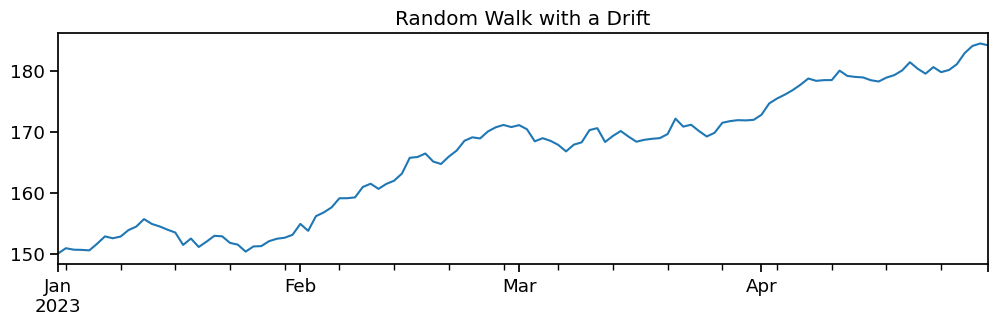

In [7]:
# Visualize the random walk with a drift data
ax = ts_rwd.plot()
ax.set_title("Random Walk with a Drift");

In [8]:
# Check for stationarity
get_adfuller_results(ts_rwd)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.189886,0,119,0.939716,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.45481,0,118,0.0,0.05,True


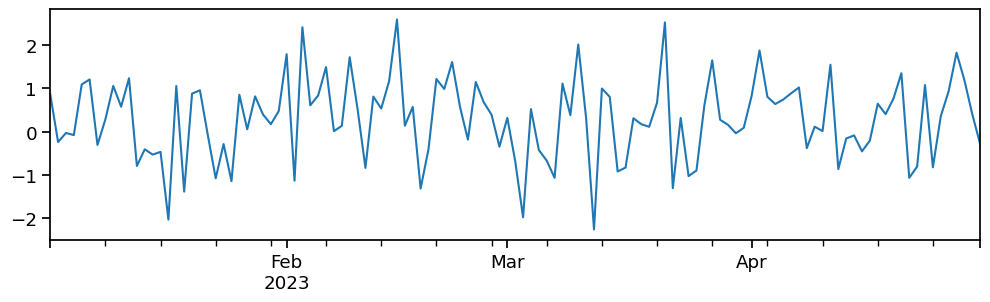

In [9]:
# Difference the data in the random walk with drift
rwd_diff = ts_rwd.diff().dropna()
rwd_diff.plot()

# Confirm the differenced data is stationary
get_adfuller_results(rwd_diff)

One differencing results is stationarity, so d = 1.

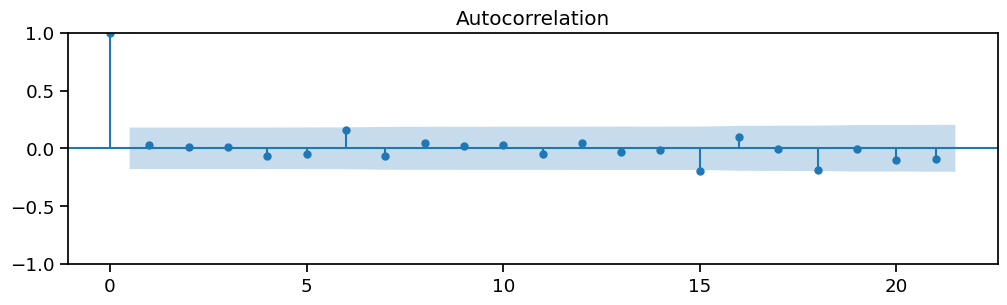

In [10]:
# Create ACF plot of random walk with drift on differenced (stationary data)
fig = tsa.graphics.plot_acf(rwd_diff)

In [11]:
# Based on ACF
q = 1

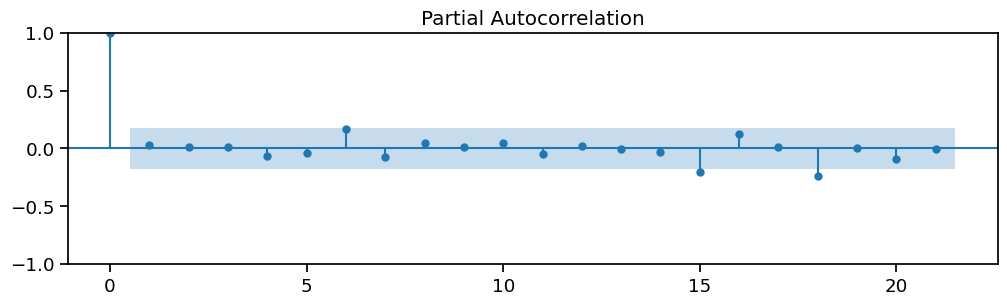

In [12]:
# Create PACF plot of random walk with drift on differenced (stationary data)
fig = tsa.graphics.plot_pacf(rwd_diff)

In [13]:
# Based on PACF
p = 1

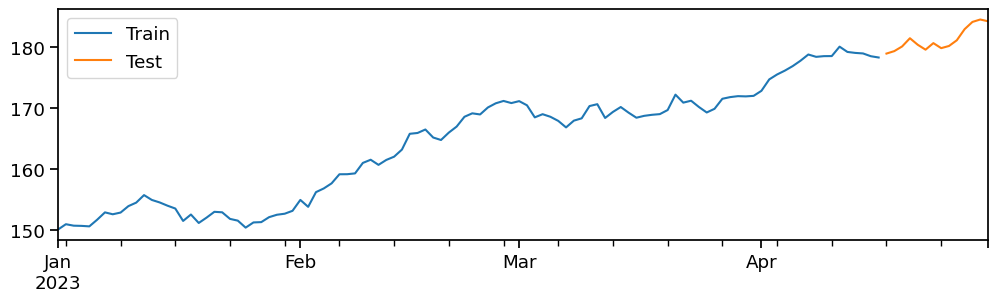

In [14]:
# TTS random walk with drift data
train_rwd, test_rwd = train_test_split(ts_rwd, test_size=14)

# Visualize the split
ax = train_rwd.plot(label='Train')
test_rwd.plot(ax=ax, label='Test')
ax.legend();

In [15]:
# AR() based on PACF plot
p = 1 

# 1 differencing to make stationary
d = 1 

# MA() based on ACF plot
q = 1

ar_ma_model_rwd = tsa.ARIMA(train_rwd, enforce_invertibility=False,
                           order=(p,d,q)).fit()

C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1.288
- MSE = 2.776
- RMSE = 1.666
- R^2 = 0.199
- MAPE = 0.70%


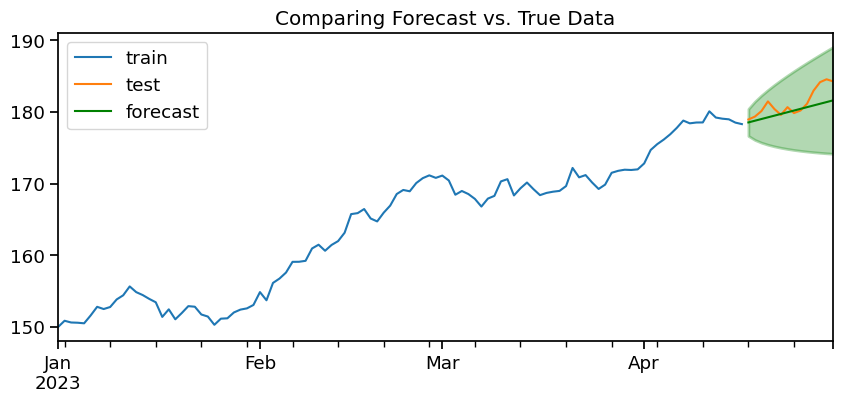

In [16]:
# Get the forecast as a summary dataframe
forecast_df_rwd = ar_ma_model_rwd.get_forecast(len(test_rwd)).summary_frame()
# Plot the forecast and true values
plot_forecast(train_rwd, test_rwd, forecast_df_rwd)
# Obtain metrics
regression_metrics_ts(test_rwd, forecast_df_rwd['mean'])